# Single cell ATAC-Seq analysis data by 10x Cell Ranger


_Cell Ranger ATAC-Seq_ https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/algorithms/overview

Information about library.

<img src='assets/1.png' width=80%>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Fragments file processing

In [2]:
import re

# Fragments file provided by cell ranger
fragments_file_gz = '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv.gz'

# BedTools doesn't work with gz file, so unzip it
!gunzip {fragments_file_gz}
fragments_file = re.sub('\.gz', '', fragments_file_gz)

# Print first line of fragments file
with open(fragments_file, 'r') as fin:        
    for line in fin:        
        print(line)
        break

gzip: /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv.gz: No such file or directory
chr1	10073	10369	AGTCCGGGTCAACTGT-1	1



# Cell Calling

_Cell Ranger ATAC-Seq_

Given `peaks.bed` graphics of BARCODE overlaps with peaks.
<img src='assets/2.png' width=80%>

For each barcode, we have the record of mapped high-quality fragments that passed all filters (the fragments.tsv file). Having determined peaks prior to this, we use the number of fragments that overlap any peak regions, for each barcode, to separate the signal from noise. **This works better in practice as compared to naively using the number of fragments per barcode.** We first subtract a depth-dependent fixed count from all barcode counts to model whitelist contamination. This fixed count is the estimated number of fragments per barcode that originated from a different GEM, assuming a contamination rate of 0.02. Then we fit a mixture model of two negative binomial distributions to capture the signal and noise. Setting an odds ratio of 1000, we separate the barcodes that correspond to real cells from the non-cell barcodes.

**We use dumb threshold for now.**

In [285]:
# Intersect using bedtools rather than pybedtools, because they are too slow!
import tempfile
import pandas as pd
import numpy as np
import os

def process_peaks_file(fragments_file, peaks_file, threshold=137):
    ! wc -l {peaks_file}
    idf = None
    ! wc -l {fragments_file}
    with tempfile.NamedTemporaryFile(prefix='intersection', suffix='.bed') as f:
        print('Computing intersection')
        ! bedtools intersect -wa -wb -a {fragments_file} -b {peaks_file} > {f.name}
        ! wc -l {f.name}
        idf = pd.read_csv(f.name, sep='\t', header=None)
        idf.columns = ['chr', 'start', 'end', 'barcode', 'reads', 'peak_chr', 'peak_start', 'peak_end']
    print('Intersection of fragments and peaks')
    print(idf.head())
    pidf = pd.pivot_table(idf, values='reads', index=['barcode'], aggfunc='count')
    pidf.reset_index(level=0, inplace=True)
    print('Barcode vs number of fragments overlapping peaks')
    print(pidf.head())
    
    counts = sorted(pidf['reads'], reverse=True)
    ns = range(1, len(counts) + 1)
    df_all = pd.DataFrame(data={'count': counts, 'n': ns})
    df_cells = df_all.loc[df_all['count'] >= threshold]
    df_noise = df_all.loc[df_all['count'] < threshold]
    print('Filtering cells by threshold', threshold)
    cells = set(pidf.loc[pidf['reads'] >= threshold]['barcode'])
    idfcells = idf.loc[[c in cells for c in idf['barcode']]]
    print('Estimated number of cells', len(df_cells))

    # create a new plot (with a title) using figure
    plt.figure(figsize=(8, 8))
    plt.plot(np.log10(df_cells['n']), np.log10(df_cells['count']), label='Cell', linewidth=3, color='orange')
    plt.plot(np.log10(df_noise['n']), np.log10(df_noise['count']), label='Noise', linewidth=3, color='blue')
    plt.xlabel('Barcodes')
    plt.ylabel('Fragments overlapping Peaks')
    plt.show()
    
    return idfcells

In [4]:
# 10x Cell ranger single cell ATAC-Seq
# idf10x = process_peaks_file(
#     fragments_file, '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/peaks.bed',
#     threshold=3000)

In [5]:
# MACS2 processing like in scatac pipeline ATAC-Seq
# MACS2 --no-model --p 1e-4
# idfmacs = process_peaks_file(
#     fragments_file, '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/macs2_p1e-4.narrowPeak',
#     threshold=20000)

105701 /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/span_f0_kd_bin100_fdr1.0E-6_gap5.bed
77486512 /mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/atac/TWDB-T-CIML007-Baseline_NK_snATAC/outs/fragments.tsv
Computing intersection
59226768 /tmp/intersectionpzikfluv.bed
Intersection of fragments and peaks
    chr  start    end             barcode  reads peak_chr  peak_start  \
0  chr1  10073  10369  AGTCCGGGTCAACTGT-1      1     chr1       10000   
1  chr1  10079  10437  CTTGCTGGTTGCAGCC-1      1     chr1       10000   
2  chr1  10085  10285  CCCTGATTCTTCATAC-1      8     chr1       10000   
3  chr1  10085  10309  TACCTATGTAAGTCTC-1      1     chr1       10000   
4  chr1  10085  10345  CCTAAAGAGCTCGTTA-1      1     chr1       10000   

   peak_end  
0     10700  
1     10700  
2     10700  
3     10700  
4     10700  
Barcode vs number of fragments overlapping peaks
              barcode  reads
0  AAACGAAAGAAACGCC-1      2
1  AAACGAAAGAAAGCAG-1      3
2  AAACGAA

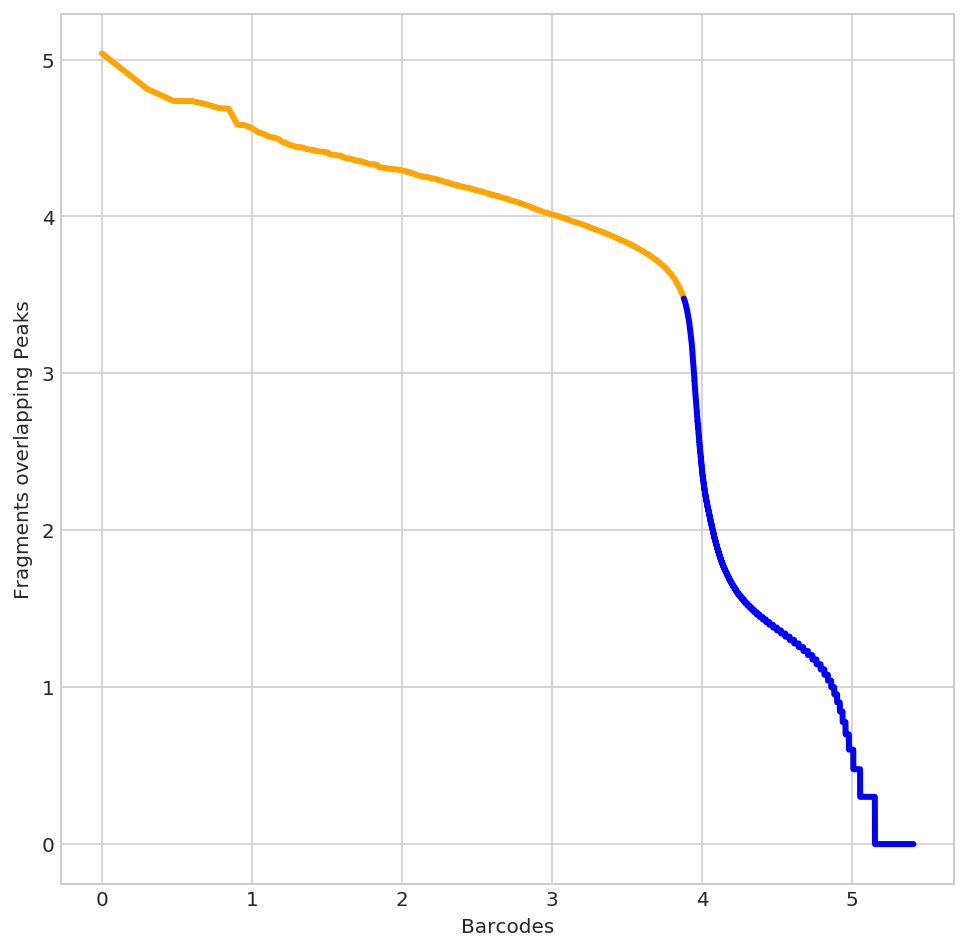

In [284]:
# SPAN - --fragment 0 --keep-dup --bin 100
idfspan = process_peaks_file(
    fragments_file, 
    '/mnt/stripe/shpynov/2019_sc_ATAC_seq_gxfer1_39174753087306/bam/span_f0_kd_bin100_fdr1.0E-6_gap5.bed',
    threshold=3000)

# Peak-Barcode Matrix

_Cell Ranger ATAC-Seq_

We produce a count matrix consisting of the counts of fragment ends (or cut sites) within each peak region for each barcode. This is the raw peak-barcode matrix and it captures the enrichment of open chromatin per barcode. The matrix is then filtered to consist of only cell barcodes, which is then used in subsequent analysis such as dimensionality reduction, clustering and visualization.

In [7]:
idf = idfspan

pdf = pd.pivot_table(idf, values='reads', 
                     index=['peak_chr', 'peak_start', 'peak_end', 'barcode'], aggfunc=np.sum).reset_index()
pdf['peak'] = pdf['peak_chr'] + ':' + pdf['peak_start'].astype(str) + '-' + pdf['peak_end'].astype(str)
pdf.drop(columns=['peak_chr', 'peak_start', 'peak_end'], inplace=True)
print('Barcode vs summary fragments overlap with peaks')
pdf.head()

Barcode vs summary fragments overlap with peaks


barcode  reads              peak
0  ACTTCCGTCTCTGCGT-1      1  chr1:10000-10700
1  CCCTGATTCTTCATAC-1      8  chr1:10000-10700
2  CCTAAAGAGCTCGTTA-1      1  chr1:10000-10700
3  CGTAAACCACCCTTAC-1      3  chr1:10000-10700
4  CTGCGTTTCGGAGTTT-1      1  chr1:10000-10700

In [8]:
fulldf = pd.pivot_table(pdf, index='peak', columns='barcode', values='reads').fillna(0)
# Remove extra labels from pivot_table columns
fulldf.columns = fulldf.columns.values
fulldf.index.name = None
fulldf.head()

AAACGAAAGACTAATG-1  AAACGAAAGAGGTGGG-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           AAACGAAAGGGCTTCC-1  AAACGAAAGTATGGGC-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           AAACGAAAGTGTTCCA-1  AAACGAAAGTTCGCGC-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 1.0                 1.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           AAACGAACAATAGTGA-1  AAACGAACACATATCG-1  \
chr10:100006200-100006800                 0.0                 1.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 1.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           AAACGAACACGCGTTG-1  AAACGAACATCCATAG-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 1.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                                  ...          TTTGTGTAGCATGATA-1  \
chr10:100006200-100006800         ...                         0.0   
chr10:100009100-100010600         ...                         0.0   
chr10:100020300-100021000         ...                         0.0   
chr10:100046000-100046500         ...                         0.0   
chr10:100148700-100148900         ...                         0.0   

                           TTTGTGTCAAGTCTCA-1  TTTGTGTCACAACGGA-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           TTTGTGTGTACCTATG-1  TTTGTGTGTGATGCGA-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                14.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           TTTGTGTGTGCCCAGT-1  TTTGTGTGTTTGATCG-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           TTTGTGTTCATCGCCT-1  TTTGTGTTCGCTATAG-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 6.0                 1.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-

In [74]:
def rpm(fulldf):
    t = fulldf.copy()
    print('RPM like normalization') 
    return  t / t.sum() * 1e6

rpm(fulldf).head()

RPM like normalization


AAACGAAAGACTAATG-1  AAACGAAAGAGGTGGG-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           AAACGAAAGGGCTTCC-1  AAACGAAAGTATGGGC-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           AAACGAAAGTGTTCCA-1  AAACGAAAGTTCGCGC-1  \
chr10:100006200-100006800            0.000000            0.000000   
chr10:100009100-100010600          113.960114          127.080951   
chr10:100020300-100021000            0.000000            0.000000   
chr10:100046000-100046500            0.000000            0.000000   
chr10:100148700-100148900            0.000000            0.000000   

                           AAACGAACAATAGTGA-1  AAACGAACACATATCG-1  \
chr10:100006200-100006800            0.000000            58.33625   
chr10:100009100-100010600            0.000000             0.00000   
chr10:100020300-100021000            0.000000             0.00000   
chr10:100046000-100046500          125.439037             0.00000   
chr10:100148700-100148900            0.000000             0.00000   

                           AAACGAACACGCGTTG-1  AAACGAACATCCATAG-1  \
chr10:100006200-100006800                 0.0            0.000000   
chr10:100009100-100010600                 0.0           49.115914   
chr10:100020300-100021000                 0.0            0.000000   
chr10:100046000-100046500                 0.0            0.000000   
chr10:100148700-100148900                 0.0            0.000000   

                                  ...          TTTGTGTAGCATGATA-1  \
chr10:100006200-100006800         ...                         0.0   
chr10:100009100-100010600         ...                         0.0   
chr10:100020300-100021000         ...                         0.0   
chr10:100046000-100046500         ...                         0.0   
chr10:100148700-100148900         ...                         0.0   

                           TTTGTGTCAAGTCTCA-1  TTTGTGTCACAACGGA-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           TTTGTGTGTACCTATG-1  TTTGTGTGTGATGCGA-1  \
chr10:100006200-100006800             0.00000                 0.0   
chr10:100009100-100010600           716.40569                 0.0   
chr10:100020300-100021000             0.00000                 0.0   
chr10:100046000-100046500             0.00000                 0.0   
chr10:100148700-100148900             0.00000                 0.0   

                           TTTGTGTGTGCCCAGT-1  TTTGTGTGTTTGATCG-1  \
chr10:100006200-100006800                 0.0                 0.0   
chr10:100009100-100010600                 0.0                 0.0   
chr10:100020300-100021000                 0.0                 0.0   
chr10:100046000-100046500                 0.0                 0.0   
chr10:100148700-100148900                 0.0                 0.0   

                           TTTGTGTTCATCGCCT-1  TTTGTGTTCGCTATAG-1  \
chr10:100006200-100006800            0.000000            0.000000   
chr10:100009100-100010600          401.821591          142.877554   
chr10:100020300-100021000            0.000000            0.000000   
chr10:100046000-

# Dimensionality Reduction, Clustering and t-SNE Projection

_Cell Ranger ATAC-Seq_

<img src='assets/3.png' width=80%>

The adopted default method is LSA.

**PCA**

For PCA, we first normalize the data to median cut site counts per barcode and log-transform it. We use a fast, scalable and memory efficient implementation of IRLBA (Augmented, Implicitly Restarted Lanczos Bidiagonalization Algorithm) that allows in-place centering and feature scaling and produces the transformed matrix along with the principal components (PC) and singular values encoding the variance explained by each PC. 
Specific to PCA, we provide k-means clustering that produces 2 to 10 clusters for visualization and analysis. We also provide a k-nearest neighbors graph-based clustering method via community detection using louvain modularity optimization algorithm. 

**LSA**

Inspired by the large body of work in the field of information retrieval, we normalize the data via the inverse-document frequency (idf) transform where each peak count is scaled by the log of the ratio of the number of barcodes in the matrix and the number of barcodes where the peak has a non-zero count. This provides greater weight to counts in peaks that occur in fewer barcodes. LSA aka SVD.
Singular value decomposition (SVD) is performed on this normalized matrix using IRLBA without scaling or centering, and produce the transformed matrix in lower dimensional space, as well as the components and the singular values signifying the importance of each component. Prior to clustering, we perform normalization to depth by scaling each barcode data point to unit L2-norm in the lower dimensional space. We found that the combination of these normalization techniques obviates the need to remove the first component. Specific to LSA, we provide k-medoids clustering that produces 2 to 10 clusters for downstream analysis. k-medoids was found to perform better than k-means on identifying correct clusters on the spherical manifold which is where the data lives after normalizing to unit norm. Similar to PCA, we also provide a graph-based clustering and visualization via t-SNE. However, similar to k-medoids clustering, we normalize the data to unit norm before performing graph-based clustering and t-SNE projection.

**t-SNE**

The transformed matrix is operated on by the t-SNE algorithm with default parameters and provides 2-D coordinates for each barcode for visualization. We also provide an optimized implementation of the Barnes Hut TSNE algorithm (which is the same as the one in our analysis pipeline for the Single Cell Gene Expression Solution). The number of dimensions is fixed to 15 as it was found to sufficiently separate clusters visually and in a biologically meaningful way when tested on peripheral blood mononuclear cells (PBMCs).



## Identification of highly variable features (feature selection)

_Seurat single cell pipeline_ https://satijalab.org/seurat/v3.0/pbmc3k_tutorial.html

We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). We and others have found that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

<img src='assets/4.png' width=30%>

RPM like normalization
log transform
Filtration of peaks with small mean < 0.1
Total peaks 105126
Filtered peaks 35543


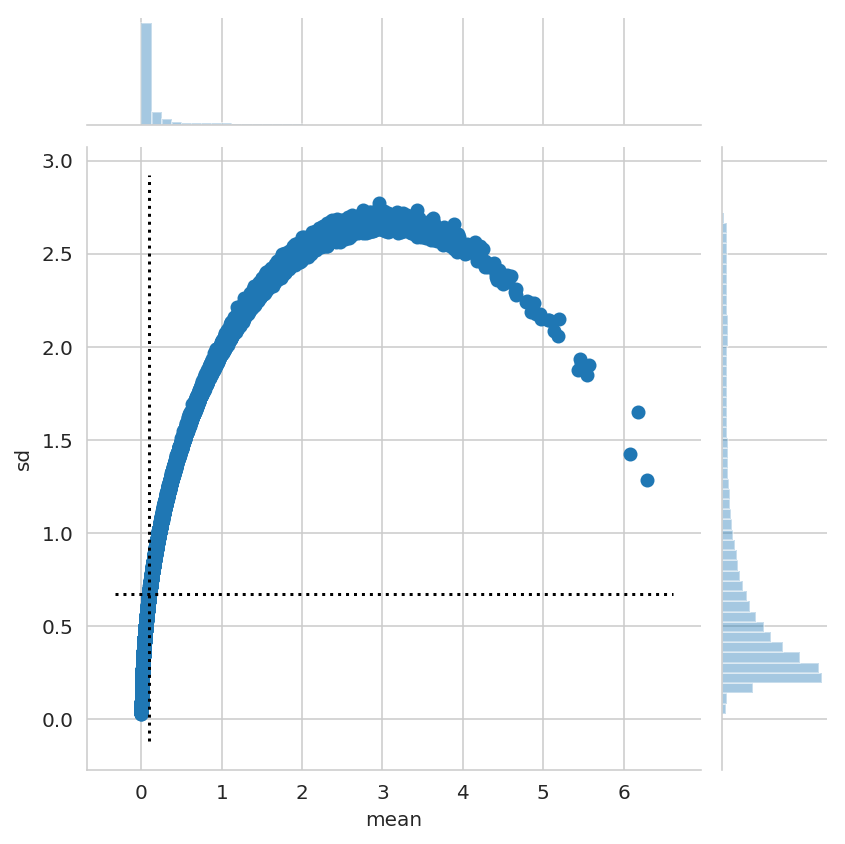

In [25]:
def feature_selection(fulldf):
    """Mean vs SD for peaks"""
    t = rpm(fulldf)
    print('log transform') 
    t = np.log(t + 1)
    t = t.transpose() # Transpose to (barcodes x peaks) format
    # print(t.mean().head())
    msdf = pd.DataFrame({'mean': t.mean(), 'sd': np.sqrt(t.var())})

    mean_threshold = 0.1
    print('Filtration of peaks with small mean <', mean_threshold)
    peaks_filter = msdf['mean'] >= mean_threshold
    print('Total peaks', len(msdf))
    print('Filtered peaks', sum(peaks_filter))

    plt.figure(figsize=(8, 8))
    g = sns.jointplot(x="mean", y="sd", data=msdf)
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    g.ax_joint.plot([mean_threshold, mean_threshold], [y0, y1], ':k')   
    min_sd = msdf.loc[peaks_filter]['sd'].min()
    g.ax_joint.plot([x0, x1], [min_sd, min_sd], ':k')   
    plt.show()
    return peaks_filter

peaks_filter = feature_selection(fulldf)

## PCA and SVD

In [330]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca(fulldf):
    normalized = rpm(fulldf)
    print('log-transform it') # It make PCA separation more clear even without proper feature selection
    normalized = np.log(normalized + 1)
    normalized = normalized.transpose() # Transpose to (barcodes x peaks) format

    print('Standard scaling')    
    scaler = StandardScaler()
    scaled = scaler.fit_transform(normalized.values) # X : numpy array of shape (n_samples, n_features)
    normalized = pd.DataFrame(scaled, index=normalized.index, columns=normalized.columns)

    # Number of dimensions recommended by Cell Ranger ATAC-Seq algorithm
    print('PCA')
    pca = PCA(n_components=15)
    result = pca.fit_transform(normalized) # X : array-like, shape (n_samples, n_features)
    print('Explained variation', np.sum(pca.explained_variance_ratio_))
    return result

In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MaxAbsScaler
    
def lsa(fulldf):
    normalized = rpm(fulldf)

    print('Inverse Document Frequency')
    # Each peak count is scaled by the log of the ratio of the number of barcodes in the matrix 
    # and the number of barcodes where the peak has a non-zero count.
    #  This provides greater weight to counts in peaks that occur in fewer barcodes.
    normalized = normalized.replace([0.0], np.NaN)
    idf = np.log(len(normalized) / normalized.count())
    normalized = normalized * idf
    normalized = normalized.replace([np.NaN], 0.0)
    normalized = normalized.transpose() # Transpose to (barcodes x peaks) format
    
    # MaxAbsScaler preserves sparsity feature of the martix
    print('MaxAbsScaler scaling')
    scaler = MaxAbsScaler()
    scaled = scaler.fit_transform(normalized.values) # X : numpy array of shape (n_samples, n_features)
    normalized = pd.DataFrame(scaled, index=normalized.index, columns=normalized.columns)

    # Number of dimensions recommended by Cell Ranger ATAC-Seq algorithm
    print('SVD')
    svd = TruncatedSVD(n_components=15)
    result = svd.fit_transform(normalized)
    print('Explained variation', np.sum(svd.explained_variance_ratio_))
    return result

PCA on features peaks
RPM like normalization
log-transform it
Standard scaling
PCA
Explained variation 0.032154044227283636
Clustering 5
Cluster 0 1714
Cluster 1 472
Cluster 2 433
Cluster 3 2272
Cluster 4 2668


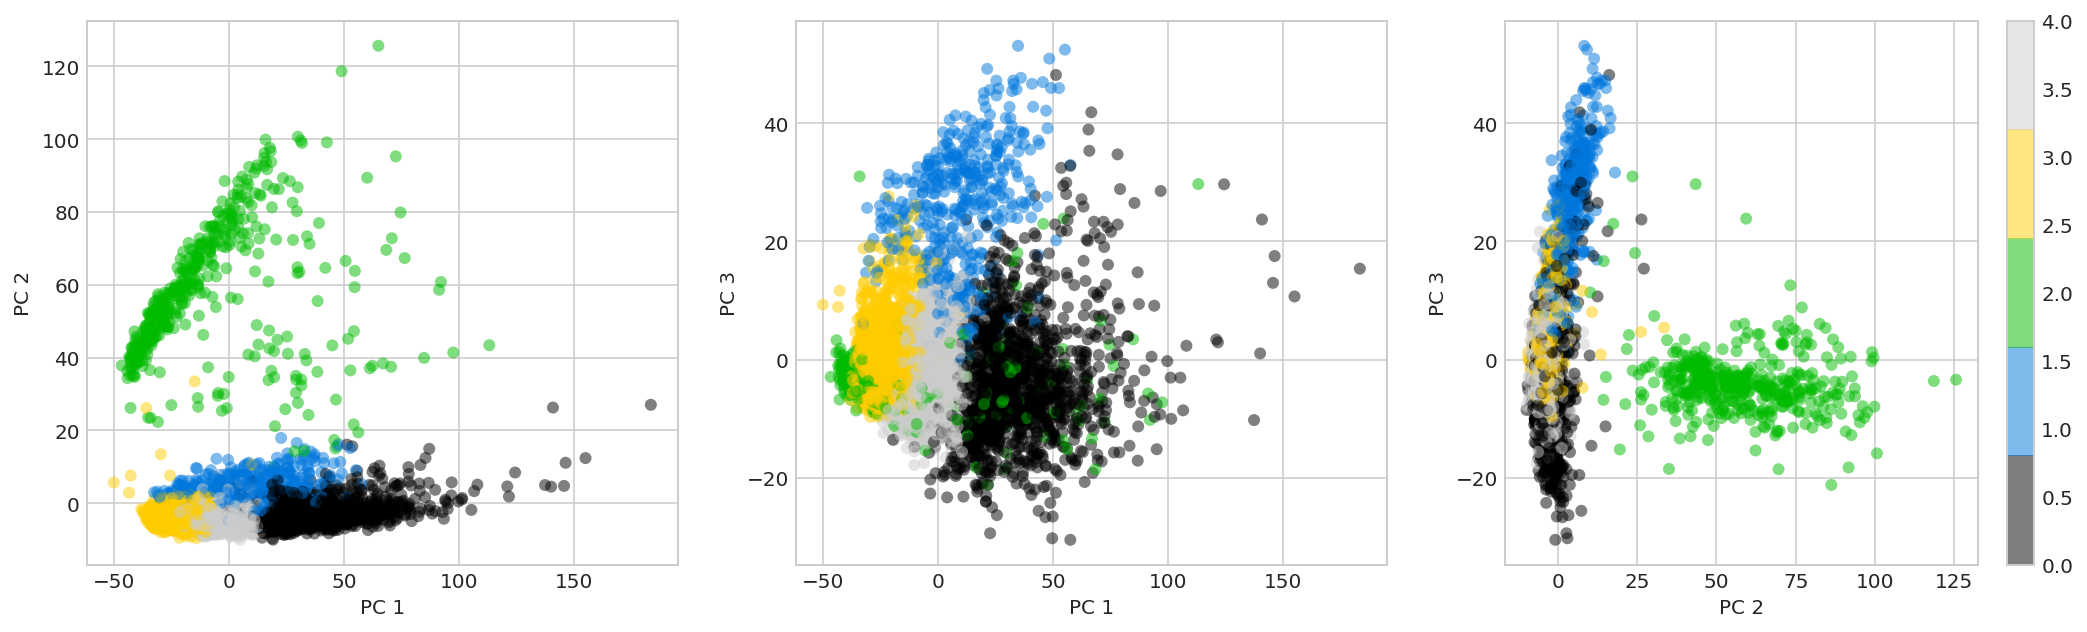

In [345]:
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
import time

def clustering(result, n_clusters):
    # 2-10 clusters is recommened values by Cell Ranger ATAC-Seq
    # Ward method as default
    print('Clustering', n_clusters)
    clusters = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(result)
    cluster_counter = Counter()
    for c in clusters:
        cluster_counter['Cluster {}'.format(c)] +=1
    for c, n in sorted(cluster_counter.items()):
        print(c, n)

    cmap = plt.cm.get_cmap('nipy_spectral', n_clusters)
    plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
    for i,(c1,c2) in enumerate([(0, 1), (0, 2), (1, 2)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(result[:, c1], result[:, c2], 
                    c=clusters, cmap=cmap, 
                    edgecolor='none', alpha=0.5)
        plt.xlabel('PC {}'.format(c1 + 1))
        plt.ylabel('PC {}'.format(c2 + 1))
    plt.colorbar()
    plt.show()
    return clusters

n_clusters = 5
# print('LSA on features peaks')
# clustering(lsa(fulldf.loc[peaks_filter]), n_clusters)
# print('---')
print('PCA on features peaks')
result = pca(fulldf.loc[peaks_filter])
clusters = clustering(result, n_clusters)

## t-SNE

In [346]:
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(result)
print('t-SNE done! Time elapsed', time.time() - time_start)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7559 samples in 0.005s...
[t-SNE] Computed neighbors for 7559 samples in 0.992s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7559
[t-SNE] Computed conditional probabilities for sample 2000 / 7559
[t-SNE] Computed conditional probabilities for sample 3000 / 7559
[t-SNE] Computed conditional probabilities for sample 4000 / 7559
[t-SNE] Computed conditional probabilities for sample 5000 / 7559
[t-SNE] Computed conditional probabilities for sample 6000 / 7559
[t-SNE] Computed conditional probabilities for sample 7000 / 7559
[t-SNE] Computed conditional probabilities for sample 7559 / 7559
[t-SNE] Mean sigma: 4.382785
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.399887
[t-SNE] Error after 1000 iterations: 2.074005
t-SNE done! Time elapsed 171.41631650924683


RPM like normalization


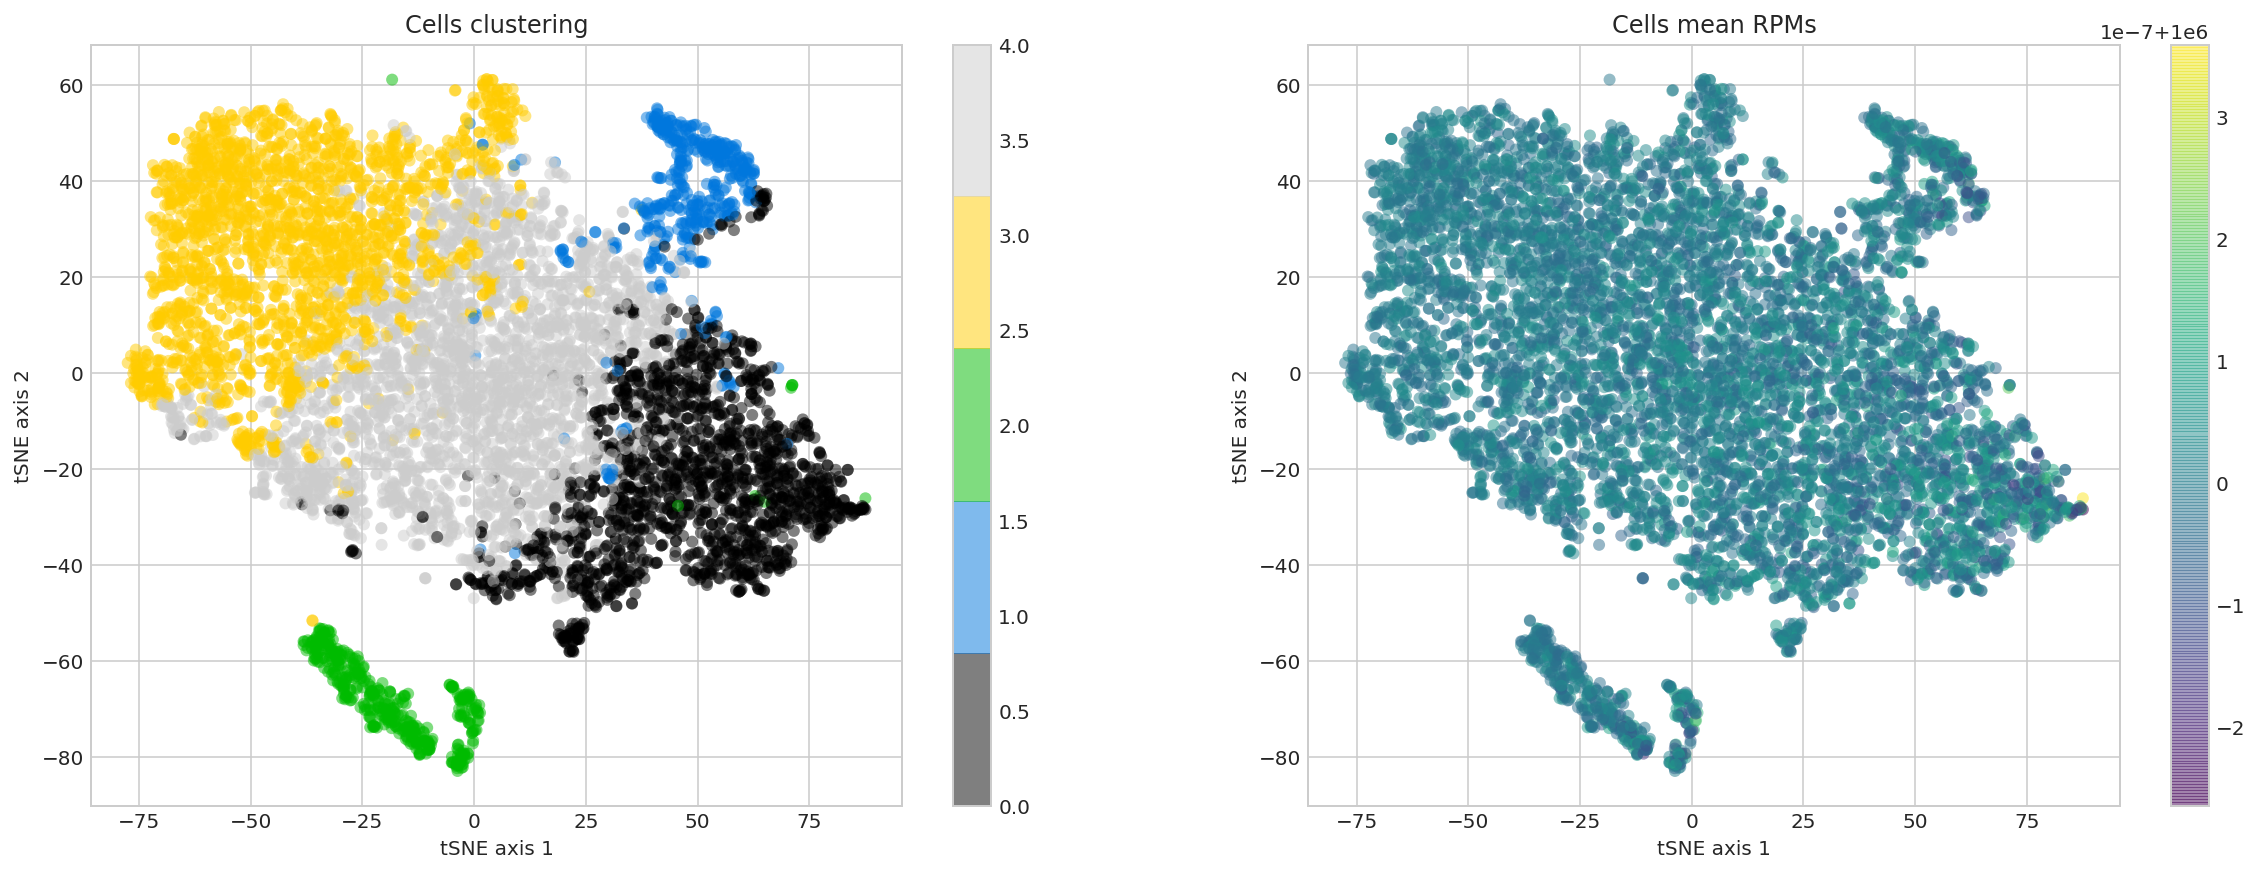

In [347]:
# TSNE based visualizations
plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ax = plt.subplot(1, 2, 1)
sc = ax.scatter(tsne_results[:,0], tsne_results[:,1], 
            c=clusters, cmap=plt.cm.get_cmap('nipy_spectral', n_clusters),
            edgecolor='none', alpha=0.5)
plt.colorbar(sc)
plt.title('Cells clustering')
plt.xlabel('tSNE axis 1')
plt.ylabel('tSNE axis 2')

ax = plt.subplot(1, 2, 2)
rpms = rpm(fulldf).sum()
sc = ax.scatter(tsne_results[:,0], tsne_results[:,1], 
            c=rpms, cmap=plt.cm.viridis,
            edgecolor='none', alpha=0.5)
plt.colorbar(sc)
plt.title('Cells mean RPMs')
plt.xlabel('tSNE axis 1')
plt.ylabel('tSNE axis 2')

plt.show()

# Differential peaks a.k.a. Markers computation

Use Wilcoxon ranked test of mean in cluster vs others with multiple correction.

In [350]:
from scipy.stats import ttest_ind
from statsmodels.sandbox.stats.multicomp import multipletests

# T-test is not 100% applicable here, Mann Whitney U is correct.
# However, number of reads is quite big in each cluster and it can be used as an approximation
def ttest(x, y):
    try:
        return ttest_ind(x, y).pvalue
    except ValueError:
        return 1.0

t_rpm = rpm(fulldf).copy().loc[peaks_filter]
t_rpm = t_rpm.transpose() # Transpose to (barcodes x peaks) format
fdr = 0.01

columns = ['cluster', 'peak', 'rpm', 'others', 'logfc', 'pval', 'adjusted_pval']
rows = []

# Per cluster RPM mean values
clusters_rpms = [t_rpm.loc[clusters == c].mean() for c in range(n_clusters)]

for cluster in range(n_clusters):
    print('Processing cluster', cluster)
    count_rpms = t_rpm.loc[clusters == cluster]
    others_rpms = t_rpm.loc[clusters != cluster]
    print('Testing')
    pvals = np.array([ttest(count_rpms[c], others_rpms[c]) for c in t_rpm.columns])  
    print('BH Multiple testing correction')
    res = multipletests(pvals, fdr, "fdr_bh")
    passed = res[0]
    print('Passed with FDR', fdr, sum(passed))
    adjusted = res[1] 
    rows_cluster = []
    for i in range(len(adjusted)):
        if passed[i]:
            peak = t_rpm.columns[i]
            count_rpm = count_rpms[peak].mean()
            others = others_rpms[peak].mean()
            logfc = np.log((value + 1e-10)  /  (others + 1e-10))
            # Filter out only single side results, ugly, I know
            # HACK: pick only for cluster with max mean RPM value
            if logfc > 0 and cluster == np.argmax([clusters_rpms[c][i] for c in range(n_clusters)]):
                row = [cluster, peak, value, others, logfc, pvals[i], adjusted[i]] 
                rows_cluster.append(dict(zip(columns, row)))
    print('Corrected max mean RPM value', len(rows_cluster))
    rows.extend(rows_cluster)

markers = pd.DataFrame(rows)
# Reorder columns
markers = markers[columns]
print('Done')
print('Total markers', len(markers))

RPM like normalization
Processing cluster 0
Testing
BH Multiple testing correction
Passed with FDR 0.01 392
Corrected max mean RPM value 18
Processing cluster 1
Testing
BH Multiple testing correction
Passed with FDR 0.01 3719
Corrected max mean RPM value 2295
Processing cluster 2
Testing
BH Multiple testing correction
Passed with FDR 0.01 13119
Corrected max mean RPM value 3947
Processing cluster 3
Testing
BH Multiple testing correction
Passed with FDR 0.01 1010
Corrected max mean RPM value 127
Processing cluster 4
Testing
BH Multiple testing correction
Passed with FDR 0.01 1094
Corrected max mean RPM value 40
Done
Total markers 6427


In [386]:
top = 20
print('Analysing top', top, 'markers')

top_markers = pd.concat([
    markers.loc[markers['cluster'] == c].sort_values(['logfc'], ascending=False).head(top) for c in range(0, n_clusters)])
    
print('Top fold change markers saved to markers.bed')
with open('markers.bed', 'w') as f:
    for t in ([re.split(':|-', p) for p in top_markers['peak']]):
        f.write('{}\t{}\t{}\n'.format(*t))

top_markers

Analysing top 20 markers
Top fold change markers saved to markers.bed


cluster                       peak        rpm     others     logfc  \
13          0   chr5:172106600-172108000  29.269985   3.813075  2.038127   
0           0    chr11:14324800-14329000  29.269985   7.222607  1.399347   
4           0    chr19:11535700-11536500  29.269985   7.541688  1.356117   
8           0      chr19:7862000-7863500  29.269985   8.973580  1.182278   
2           0    chr16:56190500-56192400  29.269985  11.387195  0.944073   
5           0      chr19:4597300-4598900  29.269985  12.012807  0.890589   
3           0        chr16:740500-741500  29.269985  12.336220  0.864023   
6           0    chr19:47572900-47573900  29.269985  14.816329  0.680833   
9           0      chr19:9795800-9796800  29.269985  17.647829  0.505950   
7           0      chr19:6199100-6200100  29.269985  18.407695  0.463794   
15          0   chr9:136243000-136246200  29.269985  18.543919  0.456421   
16          0   chr9:136409100-136411300  29.269985  18.939564  0.435310   
11          0    chr20:63552600-63554800  29.269985  21.167177  0.324111   
10          0       chr1:9428500-9429600  29.269985  21.238886  0.320729   
1           0      chr16:2720700-2721900  29.269985  23.502167  0.219470   
14          0     chr6:53793500-53796500  29.269985  26.936226  0.083091   
12          0    chr22:27918300-27920300  29.269985  28.383628  0.030750   
17          0   chr9:136974300-136980600  29.269985  28.825297  0.015309   
402         1    chr14:65302100-65304600  29.269985   0.886553  3.496976   
514         1    chr15:99502100-99502900  29.269985   1.323020  3.096646   
1051        1     chr1:60963100-60963900  29.269985   1.341788  3.082559   
187         1    chr11:47234000-47235300  29.269985   1.405848  3.035922   
1229        1    chr22:38985000-38985600  29.269985   1.481129  2.983758   
1559        1     chr3:46065200-46065800  29.269985   1.509975  2.964470   
943         1   chr1:211643100-211644200  29.269985   1.574478  2.922639   
292         1    chr12:47885100-47885800  29.269985   1.603090  2.904630   
1644        1   chr4:143357000-143357800  29.269985   1.618089  2.895317   
261         1  chr12:122104800-122105900  29.269985   1.633447  2.885870   
269         1  chr12:130994800-130995700  29.269985   1.636689  2.883887   
2148        1     chr8:29555300-29555800  29.269985   1.735808  2.825089   
...       ...                        ...        ...        ...       ...   
6328        3   chr2:118309900-118310700  29.269985   4.657858  1.838007   
6265        3  chr10:125115000-125117700  29.269985   5.302723  1.708342   
6340        3   chr3:129936600-129937300  29.269985   5.734594  1.630046   
6321        3    chr20:20360200-20361700  29.269985   5.838769  1.612043   
6317        3     chr1:54861000-54862200  29.269985   5.845872  1.610827   
6320        3     chr1:95043200-95043900  29.269985   5.885305  1.604104   
6289        3    chr13:65931900-65933200  29.269985   6.084489  1.570820   
6345        3     chr3:39387700-39389600  29.269985   6.141612  1.561475   
6324        3    chr21:26405300-26406500  29.269985   6.148382  1.560374   
6366        3   chr6:139490300-139490900  29.269985   6.168011  1.557186   
6404        4    chr20:20354700-20358800  29.269985   3.090038  2.248379   
6422        4     chr8:22745000-22745600  29.269985   3.345005  2.169095   
6407        4    chr22:44717600-44719800  29.269985   4.154756  1.952309   
6390        4  chr12:120475800-120476900  29.269985   6.768008  1.464356   
6414        4     chr3:75768000-75769400  29.269985   7.388060  1.376697   
6423        4     chr8:67602400-67604100  29.269985   8.406688  1.247535   
6392        4    chr12:19678300-19679300  29.269985   8.786326  1.203366   
6424        4       chr9:4850500-4852200  29.269985   9.905034  1.083519   
6399        4    chr17:67392200-67395500  29.269985  10.656004  1.010439   
6417        4     chr5:32279800-32281900  29.269985  12.207686  0.874497   
6412        4   chr3:188442200-188443200  29.269985  1

TSNE based visualizations for markers


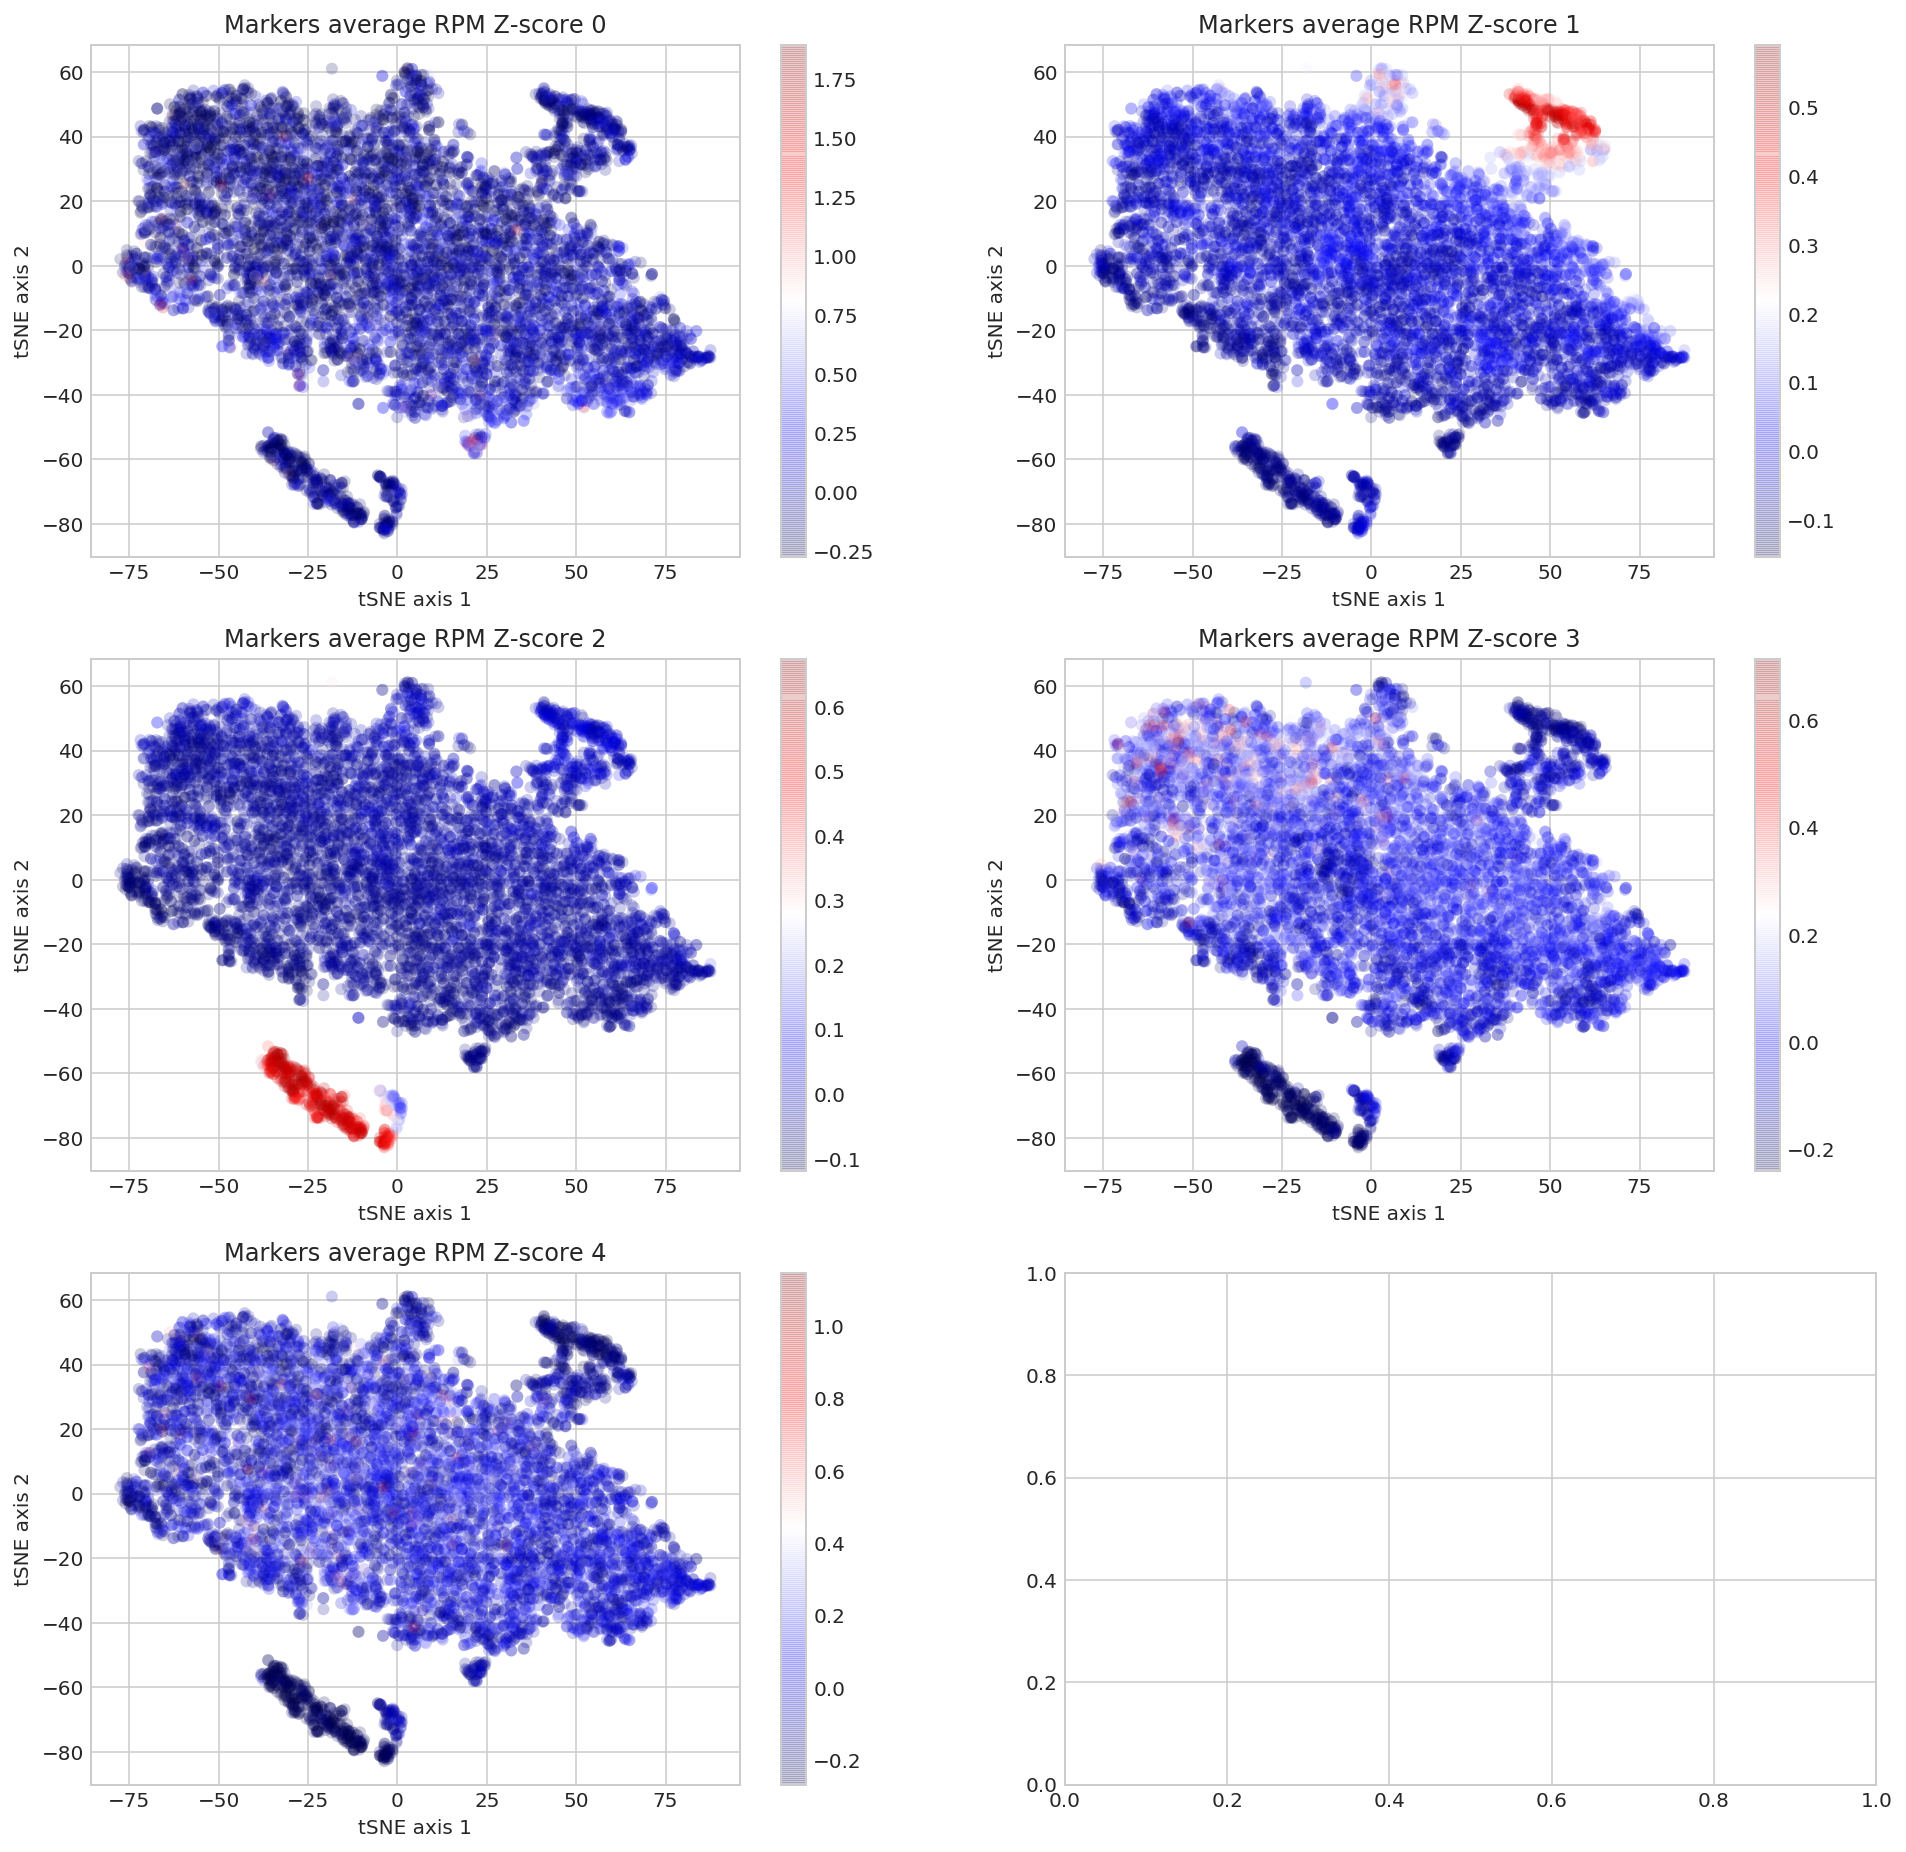

In [377]:
from scipy.stats import zscore
import math 

print('TSNE based visualizations for markers')
ncols = 2
nrows = math.ceil(n_clusters / ncols)
if 'fulldf_rpm' not in locals():
    fulldf_rpm = rpm(fulldf)

plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 8 * ncols))
for cluster in range(n_clusters):
    ax = plt.subplot(nrows, ncols, cluster + 1)
    # Table (marker for cluster x cells)
    markers_df = fulldf_rpm.loc[markers.loc[markers['cluster'] == cluster]['peak']]
    markers_df = markers_df.transpose()
    # Z scale for each peak across all cells
    for c in markers_df.columns:
        markers_df[c] = zscore(markers_df[c])
    
    # Average Z score for each cell
    zscores = markers_df.transpose().mean()
    sc = ax.scatter(tsne_results[:,0], tsne_results[:,1], 
                c=zscores, cmap=plt.cm.seismic,
                edgecolor='none', alpha=0.2)
    plt.colorbar(sc)
    plt.title('Markers average RPM Z-score {}'.format(cluster))
    plt.xlabel('tSNE axis 1')
    plt.ylabel('tSNE axis 2')
plt.show()

# BED files for clusters to visualize in JBR Genome Browser

We don't perform any filtration here, just store mean count per peak in cluster as score field in BED format. JBR allows user to filter BED tracks by score if nescessary.

Code for bed to bigbed conversion
```
for F in *cluster*.bed; do 
    echo $F; sort -k1,1 -k2,2n $F | sed 's/ /_/g'  > ${F}.sorted; 
    bedToBigBed ${F}.sorted /mnt/stripe/bio/genomes/hg38/hg38.chrom.sizes ${F/.bed/.bigBed} -type=bed6+; 
    rm ${F}.sorted; 
done
```

In [379]:
import os
import glob

print('Cleanup peaks_clusters')
for f in glob.glob('./cluster_*.bed'):
    os.remove(f)

t_rpm = rpm(fulldf).transpose() # Transpose to (barcodes x peaks) format

print('BED scoring as RPM mean')
# Same scale for all tracks
mean_max = t_rpm.mean().max()
print('Max of mean RPMs normalizer', mean_max)
# Per cluster RPM mean values
clusters_rpms = [t_rpm.loc[clusters == c].mean() for c in range(n_clusters)]

for cluster in range(n_clusters):
    counts_rpm = t_rpm.loc[clusters == cluster].mean()
    counts_rpm_md = t_rpm.loc[clusters == cluster].median()
    counts_rpm_sd = np.sqrt(t_rpm.loc[clusters == cluster].var())
    bed_file = 'cluster_{}.bed'.format(cluster)
    print('Writing cluster', cluster, 'peaks to', bed_file)
    with open(bed_file, 'w') as bed:
        for i in range(len(counts_rpm)):
            peak = counts.index[i]
            count_rpm = counts_rpm[i]
            count_rpm_md = counts_rpm_md[i]            
            count_rpm_sd = counts_rpm_sd[i]
            bed.write('{}\t{}\t{}\t{}\n'.format(
                re.sub(':|-', '\t', peak), 
                '{}RPM mean {:3.2f} md {:3.2f} sd {:3.2f}'.format(
                    '*' if cluster == np.argmax([clusters_rpms[c][i] for c in range(n_clusters)]) else '', 
                    count_rpm, count_rpm_md, count_rpm_sd), 
                min(1000, int(count_rpm * 1000 / mean_max)), 
                '.'))
print('Done')                

Cleanup peaks_clusters
RPM like normalization
BED scoring as RPM mean
Max of mean RPMs normalizer 807.529654180502
Writing cluster 0 peaks to cluster_0.bed
Writing cluster 1 peaks to cluster_1.bed
Writing cluster 2 peaks to cluster_2.bed
Writing cluster 3 peaks to cluster_3.bed
Writing cluster 4 peaks to cluster_4.bed
Done


# Differential clusters to BED for downstream analysis

Code for bed to bigbed conversion
```
for F in *cluster*.bed; do 
    echo $F; sort -k1,1 -k2,2n $F | sed 's/ /_/g'  > ${F}.sorted; 
    bedToBigBed ${F}.sorted /mnt/stripe/bio/genomes/hg38/hg38.chrom.sizes ${F/.bed/.bigBed} -type=bed6+; 
    rm ${F}.sorted; 
done
```

In [ ]:
print('Cleanup peaks_clusters')
for f in glob.glob('./diff_cluster_*.bed'):
    os.remove(f)

mlap_max = (-np.log10(markers.loc[markers['adjusted_pval'] != 0]['adjusted_pval'])).max()
print('BED scoring as -log10 adjusted pval')
print('Max of -log10 adjusted pval', mlap_max)
for c in range(n_clusters):
    bed_file = 'diff_cluster_{}.bed'.format(c)
    markers_cluster = markers.loc[markers['cluster'] == c].sort_values(['logfc'], ascending=False).iloc[::-1]
    markers_cluster.index = range(len(markers_cluster))
    print('Writing cluster', c, 'differential peaks to', bed_file)
    with open(bed_file, 'w') as bed:
        for i in range(len(markers_cluster)):
            peak = markers_cluster['peak'][i]
            ap = markers_cluster['adjusted_pval'][i]
            mlap = -np.log10(ap) if ap != 0.0 else mlap_max
            bed.write('{}\t.\t{}\t.\n'.format(re.sub(':|-', '\t', peak), int(mlap * 1000 / mlap_max)))
print('Done')                

# Genes annotating

In [380]:
# Preprocess Genes GTF
GTF_TO_BED_SH = """
GENES_GTF=$1
GENES_BED=$2
GENE_NAME_FIELD=$(cat ${GENES_GTF} | grep -v '#' | head -n 1 | awk '{for (i=1; i<NF; i++) {if ($i=="gene_name") print (i+1)}}')
cat ${GENES_GTF} |  awk -v GN=${GENE_NAME_FIELD} 'OFS="\t" {if ($3=="gene") {print $1,$4-1,$5,$GN}}' | tr -d '";' |\
    sort -k1,1 -k2,2n | sed 's/^/chr/g' > ${GENES_BED}
"""

genes_gtf = 'Homo_sapiens.GRCh38.90.gtf'
genes_bed = genes_gtf + '.bed'
if not os.path.exists(genes_bed):
    print('Downloading genes bed file')
    ! wget ftp://ftp.ensembl.org/pub/release-90/gtf/homo_sapiens/Homo_sapiens.GRCh38.90.gtf.gz
    ! gunzip -f Homo_sapiens.GRCh38.90.gtf.gz
    with tempfile.NamedTemporaryFile(prefix='', suffix='.sh', delete=False) as f:
        f.write(GTF_TO_BED_SH.encode('utf-8'))
        f.close()
        ! bash {f.name} {genes_gtf} {genes_bed} 
    os.remove(genes_gtf)
print('Genes bed file', genes_bed)   
! head Homo_sapiens.GRCh38.90.gtf.bed

Genes bed file Homo_sapiens.GRCh38.90.gtf.bed
chr1	11868	14409	DDX11L1
chr1	14403	29570	WASH7P
chr1	17368	17436	MIR6859-1
chr1	29553	31109	MIR1302-2HG
chr1	30365	30503	MIR1302-2
chr1	34553	36081	FAM138A
chr1	52472	53312	AL627309.6
chr1	57597	64116	OR4G11P
chr1	65418	71585	OR4F5
chr1	89294	133723	AL627309.1


In [381]:
print('Annotating markers with closest genes')
with tempfile.NamedTemporaryFile(delete=False) as f:
    # Save index to restore original order after sorting
    for i, t in enumerate([re.split(':|-', p) for p in markers['peak']]):
        f.write('{}\t{}\t{}\t{}\n'.format(*t, i).encode('utf-8'))
    f.close()
    closest_file = f.name + '.closest'
    sorted_file = f.name + '.sorted'
    ! sort -k1,1 -k2,2n {f.name} > {sorted_file}
    ! bedtools closest -a {sorted_file} -b {genes_bed} -D ref > {closest_file}
    closest_df = pd.read_csv(
        closest_file, sep='\t', 
        names=['peak_chr', 'peak_start', 'peak_end', 'index', 'gene_chr', 'gene_start', 'gene_end', 'gene', 'distance'])
    # Restore original sorting as 
    closest_df.sort_values(by=['index'], inplace=True)
    # Pick only first closest gene in case of several
    closest_df.drop_duplicates(['index'], inplace=True)
    # Use list to disable index
    markers['gene'] = list(closest_df['gene'])
    markers['distance'] = list(closest_df['distance'])

markers.head()

Annotating markers with closest genes


cluster                     peak        rpm     others     logfc  \
0        0  chr11:14324800-14329000  29.269985   7.222607  1.399347   
1        0    chr16:2720700-2721900  29.269985  23.502167  0.219470   
2        0  chr16:56190500-56192400  29.269985  11.387195  0.944073   
3        0      chr16:740500-741500  29.269985  12.336220  0.864023   
4        0  chr19:11535700-11536500  29.269985   7.541688  1.356117   

           pval  adjusted_pval        gene  distance  
0  1.095594e-04       0.009934       RRAS2         0  
1  8.669831e-05       0.008351      PRSS27      -150  
2  1.441845e-05       0.002058  AC007495.1         0  
3  1.122400e-05       0.001712       NARFL         0  
4  2.791297e-07       0.000107        CNN1      2217

# Preparation data for single cell explorer
Preprocess data for single cell explorer http://artyomovlab.wustl.edu/shiny/single_cell_explorer

In [387]:
from scipy import io, sparse

print('Save data_for_plot.tsv')
barcodes = fulldf.transpose().index.values
data_for_plot = pd.DataFrame(
    {'tSNE_1': tsne_results[:,0], 
     'tSNE_2': tsne_results[:,1], 
     'Cluster': clusters,
     'nCounts': fulldf.sum(),
     'nRPMs': rpm(fulldf).sum()})
data_for_plot.index = barcodes
data_for_plot.to_csv('data_for_plot.tsv', sep='\t')

print('Save RPM expData.Rda.mtx')
csc = sparse.csc_matrix(rpm(fulldf).values)
io.mmwrite('expData.Rda.mtx', csc)

print('Save barcodes.txt')
with open('barcodes.txt', 'w') as f:
    for b in fulldf.columns.values:
        f.write(b + '\n')

print('Save peaks.txt')
with open('peaks.txt', 'w') as f:
    for p in fulldf.index.values:
        f.write(p + '\n')

print('Save markers.tsv')
top_markers.to_csv('markers.tsv', index=None, sep='\t')
        
print('Done')

Save data_for_plot.tsv
RPM like normalization
Save RPM expData.Rda.mtx
RPM like normalization
Save barcodes.txt
Save peaks.txt
Save markers.tsv
Done


In [388]:
print('Converting to Rda format in R')

R_CODE = """
require(readr)
require(Matrix)
library(magrittr)

barcodes <- readr::read_tsv('barcodes.txt', col_names = F)
peaks <- readr::read_tsv('peaks.txt', col_names = F)
expData <- Matrix::readMM('expData.Rda.mtx') %>%
    magrittr::set_rownames(peaks$X1) %>%
    magrittr::set_colnames(barcodes$X1)
save(expData, file = "expData.Rda")
"""

with tempfile.NamedTemporaryFile(prefix='prepare', suffix='.R', delete=False) as f:
    f.write(R_CODE.encode('utf-8'))
    f.close()
    ! Rscript {f.name}

print('Upload `data_for_plot.tsv` and `expData.Rda` to corresponding folder and voila!')

Converting to Rda format in R
During startup - Warning message:
package ‘RevoUtils’ was built under R version 3.4.3 
Loading required package: readr
Warning message:
package ‘readr’ was built under R version 3.4.3 
Loading required package: Matrix
Warning message:
package ‘Matrix’ was built under R version 3.4.3 
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Upload `data_for_plot.tsv` and `expData.Rda` to corresponding folder and voila!


# Associated genes analysis

In [389]:
print('Top markers genes')
for cluster in range(n_clusters):
    print('Cluster', cluster)
    genes = set(top_markers.loc[top_markers['cluster'] == cluster]['gene'])
    print(', '.join(set(genes)))
    print('---')

Top markers genes
Cluster 0
RRAS2, RN7SL322P, QSOX2, NARFL, CNN1, EVI5L, AC008752.1, PTGDS, PITPNB, LRRC1, STK10, PMPCA, FNDC11, AL928921.2, PRSS27, AC011471.4, AC007495.1, AC011498.5
---
Cluster 1
NFIA-AS2, ADGRD1, UTP6, AC107954.1, DDB2, LINC01693, AC008764.1, XCR1, AC084026.1, AL160275.3, LINC02346, GNAI1, GAB1, AC015660.5, APOBEC3A, AC016813.1, AL355076.2, AC121338.1, MLXIP, AFAP1L2
---
Cluster 2
MAFB, AL117335.1, A2M, LINC01226, FKBP15, OPTC, OSM, RBM47, SYNJ2, AC011899.2, AC109826.1, UQCRHP2, DAPK1, FLVCR2, FAR2, BASP1, MTHFD1L, AC009063.2, AF246928.1, DPYSL3
---
Cluster 3
NEFL, DHCR24, SHB, CTBP2, CFAP61, SLC25A38, AP001596.1, AC013762.1, LINC01422, CUL1, JPH3, RARB, AC083906.3, AC093901.1, AC022523.3, ALG14, LINC01625, LINC00271, ATP8A1, MIR548X2
---
Cluster 4
RNU1-150P, CFAP61, ZNF717, RNA5SP431, PRR5-ARHGAP8, ARHGAP40, MTMR12, RCL1, SLC9A4, PEBP4, LPP, AC016769.1, CACNA2D2, B3GAT1, CPA6, DYNLL1, AEBP2, ITGAE, PITPNC1, STAG2
---


In [390]:
# Based on Peter Tsurinov markers list 
# https://docs.google.com/spreadsheets/d/1UZllYrMXBFRmtqGrcFhjI4CKhe4xhlnD-KTcXjwPrrs/edit#gid=448526880
MARKERS_TABLE = {
    'B cells': ['CD19', 'MS4A1', 'PTPRC', 'CD24', 'CD38', 'CD22', 'BCR'],
    'Plasma B cells': ['JCHAIN'],
    'NK cells': [ 'NCAM1', 'KLRD1', 'NCR1', 'FCGR3A', 'GNLY', 'NKG7', 'PECAM1', 'TNFRSF8', 'CD38', 
                 'CD3D', 'B3GAT1', 'IGF1R', 'NCR2', 'NCR3'],
    'Stem Cell/Precursor': [ 'CD34', 'THY1', 'PECAM1', 'KIT'],
    'Dendritic cells': [ 'ITGAX', 'HLA-DRA', 'CD1C', 'CD83', 
                    'THBD', 'CD209', 'IL3RA', 'FCER1A', 'CST3', 'CLEC7A', 'CLEC9A', 'CLEC10A', 
                        'TLR10', 'CR2', 'KEL', 'NGFR'],
    'Plasmacytoid Dendritic cells': [ 'IL3RA', 'CLEC4C', 'NRP1', 'LILRA4', 'PVRL1', 'CLEC4C', 'TLR7'],
    'CD14+ Monocyte': [ 'CD14', 'FCGR1A', 'CD33', 'LYZ', 'CD4', 'PTPRC', 'CSF3R', 'ITGAL', 'LRP1', 'SELPLG', 'MST1R'],
    'Macrophage': [ 'ITGAM', 'CD68', 'CD163', 'FCGR3A', 'MS4A7', 'CD3D', 'ITGAD', 'ITGAV', 
                   'MST1R', 'MRC2', 'VEGFA', 'VEGFB', 'VEGFC'],
    'Naive T Cells': [ 'CCR7', 'SELL'],
    'Activated T Cells': [ 'IL2RA', 'AIM1', 'LMNA'],
    'CD4 cells (T cell subtype)': [ 'CD3D', 'NCAM1', 'CD4', 'IL7R', 'SELL', 'ITGB1', 'PTPRC'], 
    'CD8 cells (T cell subtype)': [ 'CD3D', 'NCAM1', 'CD8A', 'CD8B', 'PTPRC'],
    'CD8 activated cells (T cell subtype)': [ 'CCL5'],
    'T regulatory cells (T cell subtype)': [ 'CD3D', 'NCAM1', 'FOXP3', 'IL2RA', 'CD4'],
    'Mucosal-associated invariant T cells (MAIT)': [ 'SLC4A10', 'ZBTB16', 'RORC'],
    'Megakaryocyte': [ 'PPBP', 'GP9', 'CD177', 'ITGA2B', 'GP1BA'],
    'Platelet': [ 'ITGA2B', 'ITGB3', 'PTPRC', 'GP1BA', 'SELP', 'CEACAM8', 'PTPRC', 'ITGAM', 'CD24', 'CSF3R', 'CXCR2'],
    'Mast cells (Granulocyte subtype)': [ 'FCGR2A', 'CD33', 'KIT', 'ENPP3', 
                                     'FCER1A', 'KIT', 'CEACAM8', 'PTPRC', 'ITGAM', 'CD24', 'CSF3R', 'CXCR2'],
    'Basophil (Granulocyte subtype)': [ 'CD19', 'CD22', 'IL3RA', 'ENPP3', 
                                   'FCER1A', 'ITGAM', 'CEACAM8', 'PTPRC', 'ITGAM', 'CD24', 'CSF3R', 'CXCR2'],
    'Eosinophil (Granulocyte subtype)': [ 'PTPRC', 'IL5RA', 'CCR3', 'ADGRE1', 
                                     'SIGLEC8', 'CD55', 'ITGA4', 'CEACAM8', 'PTPRC', 'ITGAM', 'CD24', 'CSF3R', 'CXCR2'],
    'Neutrophil (Granulocyte subtype)': [ 'ITGAM', 'FCGR3A', 'ITGB2', 'FCGR2A', 'CD44'],
    'Erythrocyte (Red blood cells)': [ 'GYPA', 'RRM2', 'TYMS'],
    'Plasma Cells': [ 'SDC1'],
    'Epithelial Cells': [ 'EPCAM', 'DDR2', 'MTF1'],
    'Endothelial Cells': [ 'MCAM', 'ALK', 'CD202b']
}

In [391]:
from collections import Counter

for cluster in range(n_clusters):
    print('Processing cluster', cluster)
    markers_cluster = markers.loc[markers['cluster'] == cluster]
    counter = Counter()
    genes = set(markers_cluster['gene'])
    detected = []
    for gene in genes:
        for k, v in MARKERS_TABLE.items():
            if gene in v:
                counter[k] += 1
                detected.append(gene)
    for k, v in counter.items():
        print(k, v)
    print('Detected genes', ', '.join(set(detected)))
    print('Total genes', len(genes))
    print('---')

Processing cluster 0
Detected genes 
Total genes 18
---
Processing cluster 1
Basophil (Granulocyte subtype) 1
Mucosal-associated invariant T cells (MAIT) 1
Macrophage 4
CD14+ Monocyte 1
Eosinophil (Granulocyte subtype) 4
Dendritic cells 3
NK cells 6
Stem Cell/Precursor 1
B cells 1
Neutrophil (Granulocyte subtype) 2
T regulatory cells (T cell subtype) 3
Activated T Cells 1
CD8 cells (T cell subtype) 2
Platelet 1
Plasmacytoid Dendritic cells 1
Mast cells (Granulocyte subtype) 2
CD4 cells (T cell subtype) 2
Detected genes MRC2, TNFRSF8, CCR3, ITGAM, SLC4A10, ADGRE1, LRP1, ITGA4, KIT, CR2, IGF1R, CD44, CD38, ITGAX, ITGAD, NRP1, NCAM1, GNLY, CLEC10A, CD3D, IL2RA
Total genes 1830
---
Processing cluster 2
Basophil (Granulocyte subtype) 4
Mucosal-associated invariant T cells (MAIT) 1
Macrophage 2
CD14+ Monocyte 1
Eosinophil (Granulocyte subtype) 2
Megakaryocyte 1
NK cells 2
Dendritic cells 6
Stem Cell/Precursor 1
B cells 3
Neutrophil (Granulocyte subtype) 3
Activated T Cells 1
Platelet 3
Plasm

# Versus TWDB-T-CIML007-Baseline_NK_5prime

In [392]:
gex = pd.read_csv('gex_5.tsv', sep='\t')
gex_markers = {
    1: list(gex.loc[gex['pvalue1'] < 0.05]['gene_name']),
    2: list(gex.loc[gex['pvalue2'] < 0.05]['gene_name']),
    3: list(gex.loc[gex['pvalue3'] < 0.05]['gene_name']),
    4: list(gex.loc[gex['pvalue4'] < 0.05]['gene_name']),
    5: list(gex.loc[gex['pvalue5'] < 0.05]['gene_name']),    
}
gex_markers

for cluster in range(n_clusters):
    print('Processing cluster', cluster)
    genes = set(markers.loc[markers['cluster'] == cluster]['gene'])
    for k, v in gex_markers.items():
        print(k, ':', sum([g in genes for g in v]), 'of', len(v))

Processing cluster 0
1 : 1 of 101
2 : 0 of 82
3 : 0 of 1
4 : 1 of 136
5 : 0 of 54
Processing cluster 1
1 : 15 of 101
2 : 12 of 82
3 : 0 of 1
4 : 17 of 136
5 : 13 of 54
Processing cluster 2
1 : 40 of 101
2 : 34 of 82
3 : 0 of 1
4 : 45 of 136
5 : 26 of 54
Processing cluster 3
1 : 0 of 101
2 : 0 of 82
3 : 0 of 1
4 : 0 of 136
5 : 0 of 54
Processing cluster 4
1 : 0 of 101
2 : 0 of 82
3 : 0 of 1
4 : 0 of 136
5 : 0 of 54
